# SideQICK demo notebook
This was used for the demo presentation on 2022-11-30.

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from user_client import UserClient, WorkloadManager
from tqdm.auto import tqdm
%pylab inline

Could not import QickSoc: name 'xrfdc' is not defined
Populating the interactive namespace from numpy and matplotlib


## Set up initial configuration
You should have a config file in ~/.config/qick.conf.admin with admin credentials, which we will use to create the demo device and user.

In [2]:
!rm ~/.cache/qick.tokens
# use admin config for the setup steps
!cp ~/.config/qick.conf.admin ~/.config/qick.conf
# start new client
client = UserClient()

## add a device (and start the device client)

In [3]:
client.add_device("QICK Demo Device")

# this is equivalent:
# ./user_client.py add_device "QICK Demo Device"

initial auth for admin@example.com:
········
Device successfully added!

Put the following in the config file /etc/qick/config:
[service]
api_url = [REDACTED]
oauth_url = [REDACTED]
[device]
name = QICK Demo Device AAA
id = [REDACTED]

If using UserClient for workload submission, the [device] block is needed in the client config as well.

Put the following in the device credentials file /etc/qick/credentials:
[credentials]
id = [REDACTED]
secret = [REDACTED]


## add a user (and log in to the web UI)
You should of course use a real e-mail address, since a temporary password will be sent there.

In [4]:
client.add_user("name@example.com", "Demo User")

# this is equivalent:
# ./user_client.py add_user name@example.com "Demo User"

User successfully added! They should check their e-mail for a temporary password.

They should put the following in ~/.config/qick.conf:
[service]
api_url = [REDACTED]
cognito_url = [REDACTED]
cognito_clientid = [REDACTED]
cognito_userpool = [REDACTED]
[user]
username = name@example.com


## define the QICK program and the workload

In [5]:
class FSGenLoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        for iCh, ch in enumerate(cfg["gen_chs"]):  # configure the pulse lengths and upconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=cfg['nqz'][iCh], ro_ch=cfg["ro_chs"][0])
            
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(cfg['pulse_freq'],gen_ch=ch,ro_ch=cfg["ro_chs"][0]),
                         gain=cfg['pulse_gain'],
                         phase=0)

            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")

        for iCh, ch in enumerate(cfg["ro_chs"]):  # configure the readout lengths and downconversion frequencies
            length_ro = self.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            
            self.declare_readout(ch=ch, freq=cfg["pulse_freq"],
                                 length=length_ro,
                                 gen_ch=cfg["gen_chs"][0])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["gen_chs"],
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

        
def noise(raw, length):
    """Helper function for analysis
    """
    diq = np.dot(raw, np.array([1,1j]))/length
    dmean = np.mean(diq,axis=1)
    dmag = np.abs(dmean)
    drotated = diq*np.exp(-1j*np.angle(dmean))[:,np.newaxis]
    drmsmag = np.std(np.real(drotated),axis=1) # noise in the radial direction
    drmsrot = np.std(np.imag(drotated), axis=1) # noise in the azimuth direction
    return drmsmag, drmsrot

class SweepWorkload(WorkloadManager):
    def __init__(self, soccfg, start, stop, n_pts):
        self.freqs = np.linspace(start=start, stop=stop, num=n_pts)
        self.amps = np.zeros((n_pts,2))
        self.noises_amp = np.zeros((n_pts,2))
        self.noises_pha = np.zeros((n_pts,2))
        
        self.config = {
            'gen_chs': [0,4],
            'ro_chs': [0,1],
            'nqz': [1,2],
            'style': 'const',
            'pulse_gain': 32000,
            'adc_trig_offset': 0.45,
            'length': 4,
            'readout_padding': -0.1,
            'relax_delay': 1,
            'reps': 1000,
            'rounds': 1,
        }
        self.dec_config = {
            'pulse_freq': 4000,
            'length': 1,
            'readout_padding': 0.1,
            'reps': 1,
            'soft_avgs': 1000
        }
        super().__init__(soccfg)
        
    def do_stuff(self, make_progs=False, write_progs=False, read_results=False):
        if make_progs:
            # create and add a program
            prog = FSGenLoopbackProgram(self.soccfg, {**self.config, **self.dec_config})
            self.add_program(prog)
        else:
            prog = next(self.prog_iterator)
        if write_progs:
            # now call add_acquire
            self.add_decimated(prog)
        if read_results:
            res = next(self.result_iterator)
            # now do something with "res"
            self.dec = res["dec"][...]
            self.dec_t = prog.cycles2us(np.arange(self.dec.shape[1]), ro_ch=self.config['ro_chs'][0])
        
        for i, f in tqdm(list(enumerate(self.freqs))):
            self.config['pulse_freq'] = f
            if make_progs:
                # create and add a program
                prog = FSGenLoopbackProgram(self.soccfg, self.config)
                self.add_program(prog)
            else:
                prog = next(self.prog_iterator)
            if write_progs:
                # now call add_acquire
                self.add_acquire(prog, save_raw=True)
            if read_results:
                res = next(self.result_iterator)
                # now do something with "res"
                avg = res["avg"][...]
                raw = res["raw"][...]
                self.amps[i] = np.abs(avg[:,0,:].dot(np.array([1,1j])))
                noise_amp, noise_pha = noise(raw, prog.ro_chs[0]['length'])
                self.noises_amp[i] = noise_amp
                self.noises_pha[i] = noise_pha
                
    def display(self):
        fig, axs = plt.subplots(4,1,figsize=(10,20))
        for ii, iq in enumerate(self.dec):
            plot = axs[2*ii]
            plot.plot(self.dec_t, iq[:,0], label="I value, ADC %d"%(self.config['ro_chs'][ii]))
            plot.plot(self.dec_t, iq[:,1], label="Q value, ADC %d"%(self.config['ro_chs'][ii]))
            plot.plot(self.dec_t, np.abs(iq.dot([1, 1j])), label="mag, ADC %d"%(self.config['ro_chs'][ii]))
            plot.set_ylabel("a.u.")
            plot.set_xlabel("Time [us]")
            plot.set_title("Averages = " + str(self.dec_config["soft_avgs"]))
            plot.legend()

            plot = axs[2*ii+1]
            plot.semilogy(self.freqs, self.amps[:,ii], label="mean")
            plot.semilogy(self.freqs, self.noises_amp[:,ii], label="amplitude noise")
            plot.semilogy(self.freqs, self.noises_pha[:,ii], label="phase noise")
            plot.set_ylabel("avg a.u.")
            plot.set_xlabel("Frequency [MHz]")
            plot.set_title("Averages = " + str(self.config["reps"]))
            plot.legend()

## Manual upload and download (using WorkloadManager class, but not UserClient)

In [6]:
import json
with open('/home/meeg/Downloads/664279d8-f236-4e28-83f4-27cce968d643-configuration.json', 'rt') as f:
    soccfg = QickConfig(json.load(f))
print(soccfg)


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v6 - tProc out

In [7]:
print("initializing WorkloadManager:")
expt = SweepWorkload(soccfg, start=1, stop=10000, n_pts=1001)

print("writing programs to workload file:")
expt.write_progs("test.json.gz")

initializing WorkloadManager:


  0%|          | 0/1001 [00:00<?, ?it/s]

writing programs to workload file:


  0%|          | 0/1001 [00:00<?, ?it/s]

reading results:


  0%|          | 0/1001 [00:00<?, ?it/s]

plotting results


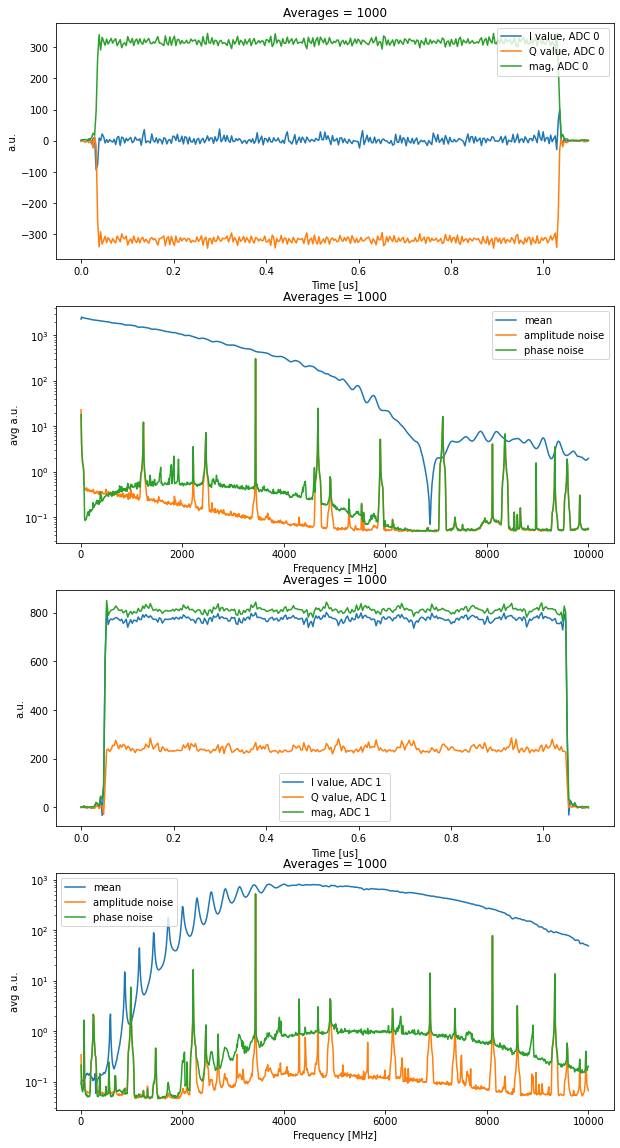

In [8]:
print("reading results:")
with open('/home/meeg/Downloads/3707e60f-365b-40e8-b759-8942554ac96c-output', 'rb') as resultsfile:
    expt.read_results(resultsfile)

print("plotting results")
expt.display()

## Using UserClient to upload work and download results

In [9]:
# start new client
client = UserClient()

In [10]:
# download QICK configuration
soccfg = QickConfig(client.get_soccfg())
print(soccfg)

initial auth for [REDACTED]:
········

QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 

initializing WorkloadManager:


  0%|          | 0/1001 [00:00<?, ?it/s]

writing programs to workload file:


  0%|          | 0/1001 [00:00<?, ?it/s]

submitting workload:
workload is submitted, work ID df57d80e-de90-4bbc-a152-4a420654f8f6
workload is CREATED.
workload is READY...
workload is EXECUTING..................
workload is UPLOADING.......
workload is DONE
reading results:


  0%|          | 0/1001 [00:00<?, ?it/s]

plotting results


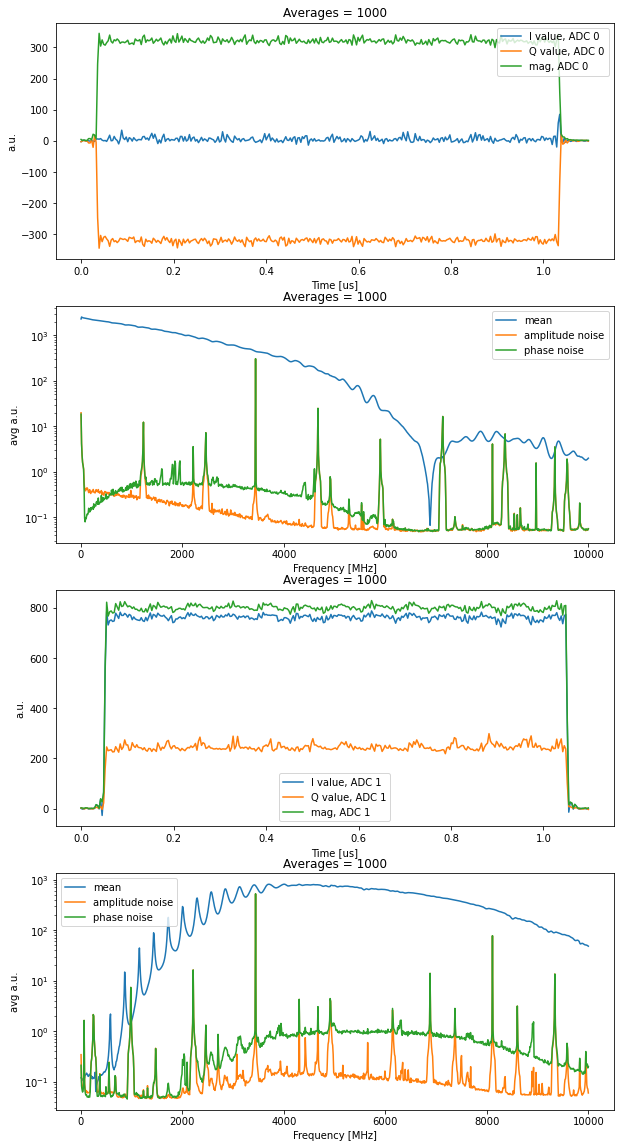

In [11]:
print("initializing WorkloadManager:")
expt = SweepWorkload(soccfg, start=1, stop=10000, n_pts=1001)

print("writing programs to workload file:")
with expt.write_progs() as workloadfile:
    print("submitting workload:")
    work_id = client.create_work(workloadfile, priority="LOW")
print("workload is submitted, work ID " + work_id)

client.wait_until_done(work_id, progress=True)

print("reading results:")
with client.get_results(work_id) as resultsfile:
    expt.read_results(resultsfile)

print("plotting results")
expt.display()